In [2]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
import torchvision

In [32]:
training_data_set = torchvision.datasets.MNIST('./dataset/mnist/training.pt', train=True, download=True)
test_data_set = torchvision.datasets.MNIST('./dataset/mnist/test.pt', train=False, download=True)

Number of samples in the training set: 60000
Number of samples in the test set: 10000
<PIL.Image.Image image mode=L size=28x28 at 0x21A164A8AC8> -> tensor(5)


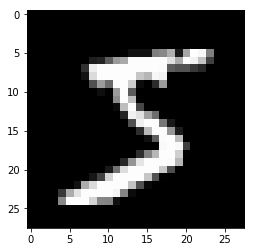

In [33]:
"""
Observing some of the data
"""
print("Number of samples in the training set:", len(training_data_set))
print("Number of samples in the test set:", len(test_data_set))
image, target = training_data_set[0]
print(image, "->", target)
plt.imshow(image)

In [34]:
"""
How to transform the data into vectors
"""
pipeline = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.2, 0.2, 0.2])
])
xs = pipeline(image)
xs.shape

torch.Size([1, 28, 28])

In [35]:
"""
Working with data loader for images
"""

# You need to transform the data to vectors to put it inside a data loader
training_data_set.transform = pipeline
test_data_set.transform = pipeline

data_loader = DataLoader(training_data_set, batch_size=2, shuffle=True)
for images, targets in data_loader:
    print(images)
    print(targets)
    break

tensor([[[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]],


        [[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]]])
tensor([6, 9])


Training loss: 267.6142434030771
Accuracy: 54175/60000 (90.29%)
Training loss: 200.17241472750902
Accuracy: 54365/60000 (90.61%)
Training loss: 191.14692268520594
Accuracy: 54980/60000 (91.63%)
Training loss: 185.5112028643489
Accuracy: 55296/60000 (92.16%)
Training loss: 182.9945149719715
Accuracy: 54808/60000 (91.35%)
Training loss: 182.87768813222647
Accuracy: 54980/60000 (91.63%)
Training loss: 179.92411387711763
Accuracy: 55295/60000 (92.16%)
Training loss: 179.46111898124218
Accuracy: 54915/60000 (91.53%)
Training loss: 177.51823166012764
Accuracy: 55313/60000 (92.19%)
Training loss: 177.93278969824314
Accuracy: 55382/60000 (92.30%)


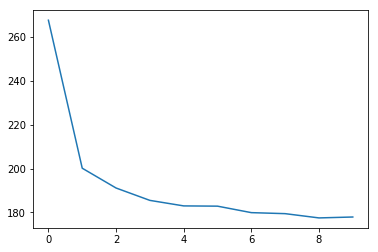

In [96]:
"""
Training a basic Linear classifier for images
"""

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28 * 28, 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

training_data_set.transform = pipeline
test_data_set.transform = pipeline   
    
linear_model = LinearClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_model.parameters(), lr=1e-3)

training_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)
test_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)

losses = []

for epoch in range(10):
    cumulative_loss = 0.
    linear_model.train()
    for images, targets in training_data_loader:
        optimizer.zero_grad()
        got = linear_model(images, with_softmax=False)
        loss = criterion(got, targets)
        cumulative_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print("Training loss: {0}".format(cumulative_loss))
    losses.append(cumulative_loss)
    
    correct = 0
    total = 0
    linear_model.eval()
    for images, targets in test_data_loader:
        got = linear_model(images, with_softmax=True)
        predicted = torch.argmax(got, dim=-1)
        predicted = predicted.view(-1)
        targets = targets.view(-1)
        correct += (predicted == targets).sum().item()
        total += len(targets)
    
    print("Accuracy: {0}/{1} ({2:.2f}%)".format(correct, total, 100 * correct/total))

plt.plot(losses)
plt.show()

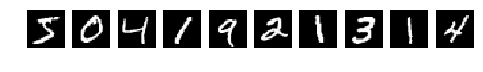

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [97]:
"""
Trying the model
"""

def predict(model, image_indexes):
    fig, ax = plt.subplots(figsize=(8, 8), ncols=len(image_indexes))
    predicted = []
    training_data_set.transform = None
    for image_idx in image_indexes:
        image, target = training_data_set[image_idx]
        xs = pipeline(image)
        xs = xs.unsqueeze(dim=0)
        ys = model(xs, with_softmax=True)
        predicted.append(torch.argmax(ys, dim=-1).item())
        ax[image_idx].imshow(image)
        ax[image_idx].set_axis_off()
    plt.show()
    print(predicted)

predict(linear_model, range(10))